## Computational Workflow Schematic
![Computational Workflow Schematic](images/fig_3.png)

# Insulator classification and Band gap Regression models for Double Oxide Perovskites
We implement two models in this notebook.


## i) Classification model 
- To separate materials that have a bandgap greater than 0.5 eV (Insulators) from those that have a very narrow band gap ( < 0.5 eV).

## ii) Regression model 
- To predict the band gap of materials classified by (i) as insulators

We will first look at how we build these models and then look at applying them on unseen data to predict new materials

### Since we are working with large datasets, we use the python [pickle](https://docs.python.org/3/library/pickle.html) module to manage our dataset. So we load our data management packages and some utility functions we have written to prepare the data for the models.

In [1]:
import pickle
import pandas as pd
import perovmldis.engine as en
from perovmldis.data_utilities.generate_data import generate_feature_labels, csv_to_json, prepare_data

###  Next, we load our training compounds, element data and candidate compounds

In [2]:
with open('data/training_compounds.pkl', 'rb') as f:
                training_compounds = pickle.load(f)
with open('data/element_data.pkl', 'rb') as f:
                ele_data = pickle.load(f)

In [ ]:
ele_data['Al'].keys()

In [ ]:
training_compounds[10].keys()

### Then, we populate the training data with all the features we have finalized

In [3]:
dft_training_data = en.create_perovskite_stability_training_data(training_compounds, ele_data)

In [ ]:
training_compounds[10].keys()

In [ ]:
training_compounds[1200]

## Classification of oxide perovskites into narrow and wide band gap materials

### Use the training data to train the classification model. We also print out the performance metrics, confusion matrices (we use a 80/20 split for training and testing)  and plot the feature importances

------------------------------------------------------------------------
Insulator classification Model Performance
------------------------------------------------------------------------
RFC Test Precision: 0.9236641221374046
RFC Test Recall: 0.8581560283687943
RFC Test Accuracy: 0.9418604651162791
Test confusion matrix
[[365  10]
 [ 20 121]]
Train confusion matrix
[[3200    2]
 [  15 1419]]
 All data confusion matrix
[[3565   12]
 [  35 1540]]
------------------------------------------------------------------------


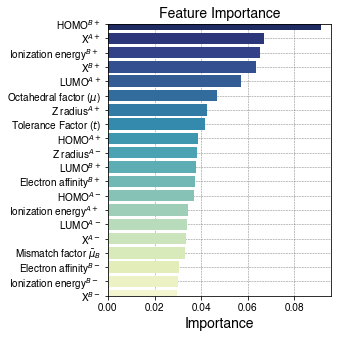

In [4]:
insulator_feature_list, test_features,test_labels,insulator_clf = en.run_insulator_classification(dft_training_data)

## Next, we analyze the performance of our classification model, my plotting the performance curves: 

i) The Receiver Operating Characteristic (ROC) curve

ii) Precision Recall (PR) curve

Ideally, you will spend some time fine tuning your model, adding more training data if necessary, until you are satisfied with the performance. Here we show our finished models.

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       375
           1       0.92      0.86      0.89       141

    accuracy                           0.94       516
   macro avg       0.94      0.92      0.93       516
weighted avg       0.94      0.94      0.94       516



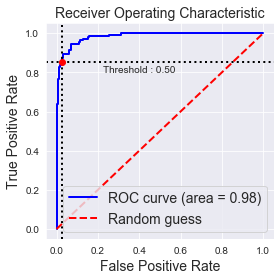

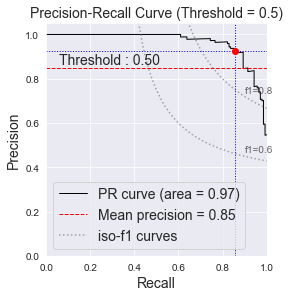

In [5]:
from perovmldis.ML_utilities.ML_plotting import plot_roc_curves
plot_roc_curves(test_features,test_labels, insulator_clf)

## Regression model to predict band gap  of oxide perovskites expected to have a wide band gap

### First, we extract the training data for band gap regression. We train the regression model only using those data which have a wide band gap ( > 0.5 eV)


In [6]:
bandgap_training_data = en.create_bandgap_regression_training_data(training_compounds, ele_data)

## Plot the training data

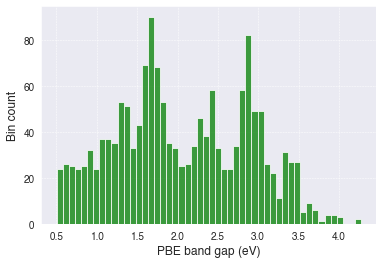

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
plot_data = pd.DataFrame(bandgap_training_data)
fig, ax = plt.subplots()
x = plot_data['PBE_band_gap'].values
n, bins, patches = plt.hist(x, 50, facecolor='g', alpha=0.75)
plt.xlabel('PBE band gap (eV)',fontsize=12) 
plt.ylabel('Bin count',fontsize=12) 
plt.grid(linestyle='--', linewidth='0.5')

##  Use the training data to train the regression model. 

### We also print out the performance metrics and plot the feature importances, the parity curves for training and testing and the confidence intervals

We use a 80/20 split for training and testing

------------------------------------------------------------------------
Band gap regression Model Performance
------------------------------------------------------------------------
Band gap regression Training
MSE: 0.0186
MAE: 0.0821
R2_coefficient: 0.9732
------------------------------------------------------------------------
Band gap regression Test
MSE: 0.3296
MAE: 0.2005
R2_coefficient: 0.8197
------------------------------------------------------------------------


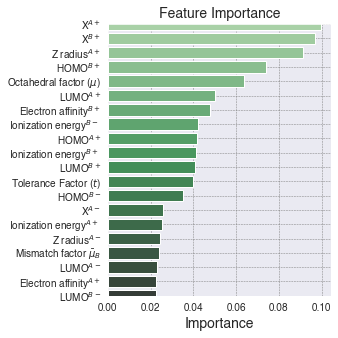

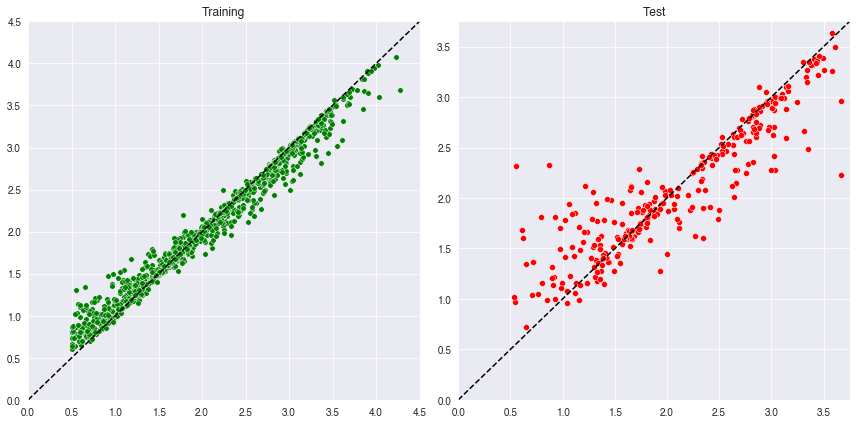

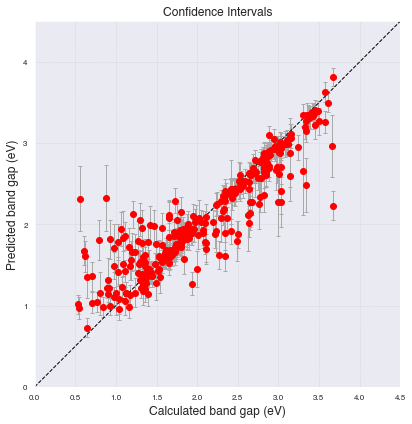

In [9]:
regression_feature_list, best_estimator = en.run_bandgap_regression(bandgap_training_data)

## Predict new oxide perovskites with wide band gap

In [10]:
all_candidates = csv_to_json('data/stable_formable_candidates.csv')
print(len(all_candidates))

476291


In [11]:
condensed_candidate_data = all_candidates[0:100000]
all_candidate_data = prepare_data(condensed_candidate_data,ele_data)

### We clear some memory by deleting some data we no longer need

In [12]:
del dft_training_data 
del all_candidates
import gc
gc.collect()

19323

In [13]:
from perovmldis.ML_utilities.RFC_functions import classify_data
insulator_candidates = classify_data(all_candidate_data, insulator_feature_list, insulator_clf, pred_label='predicted_Insulator', data_type='prediction', model_type='insulator')

Classify candidates
Number of compounds: 100000
Number of classified True compounds: 3000


### Of the 1350216 candidates, 16950 are predicted to be insulators

In [14]:
from perovmldis.ML_utilities.RFR_functions import predict_regression
wide_bandgap_data = predict_regression(insulator_candidates, regression_feature_list, best_estimator, pred_label='Predicted_band_gap')

Number of compounds: 3000
Number of wide bandgap compounds: 3000


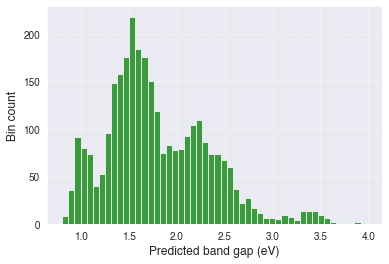

In [18]:
plot_predicted_data = pd.DataFrame(wide_bandgap_data)
fig, ax = plt.subplots()
x = plot_predicted_data['Predicted_band_gap'].values
n, bins, patches = plt.hist(x, 50, facecolor='g', alpha=0.75)
plt.xlabel('Predicted band gap (eV)',fontsize=12) 
plt.ylabel('Bin count',fontsize=12) 
plt.grid(linestyle='--', linewidth='0.5')

## More analysis: Partial Dependence Plots (PDPs)

In [20]:
importances = list(best_estimator.feature_importances_)
feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(regression_feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
ranked_features = []
for i in range(5):
    ranked_features.append(feature_importances[i][0])	
dataset = pd.DataFrame(bandgap_training_data)
ranked_labels = generate_feature_labels(ranked_features)
print(ranked_labels)

['X$^{A+}$', 'X$^{B+}$', 'Z radius$^{A+}$', 'HOMO$^{B+}$', 'Octahedral factor ($\\mu$)']


### We now plot the PDPs for the top three features identified by the regression model.

In [ ]:
from perovmldis.ML_utilities.ML_plotting import plot_pdp_plots
plot_pdp_plots(best_estimator,dataset,regression_feature_list,ranked_features[0:3],ranked_labels[0:3])